In [67]:
# Importing the required libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus, graphviz

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier


%matplotlib inline

In [68]:
# Reading the csv file and putting it into 'df' object.
df = pd.read_csv('heart_v2.csv')

In [69]:
df.shape

(270, 5)

In [70]:
df.columns

Index(['age', 'sex', 'BP', 'cholestrol', 'heart disease'], dtype='object')

In [71]:
df.head()

,age,sex,BP,cholestrol,heart disease
0,70,1,130,322,1
1,67,0,115,564,0
2,57,1,124,261,1
3,64,1,128,263,0
4,74,0,120,269,0


In [72]:
# Putting feature variable to X
X = df.drop('heart disease',axis=1)

# Putting response variable to y
y = df['heart disease']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
X_train.shape, X_test.shape

((189, 4), (81, 4))

Fitting the decision tree with default hyperparameters, apart from max_depth which is 3 so that we can plot and read the tree.

In [74]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [75]:
!pip install six

##### Create helper functions to evaluate the model performance and create the graph for DT

In [76]:
def get_dt_graph(dt_classifier):
    dot_data = StringIO()  

    export_graphviz(dt_classifier, out_file=dot_data, filled=True, rounded=True,
                feature_names=X.columns, 
                class_names=['No Disease', "Disease"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [77]:
def evaluate_model(dt_classifier):
    y_train_pred = dt_classifier.predict(X_train)
    y_test_pred = dt_classifier.predict(X_test)
    print("Train set performance")
    print(accuracy_score(y_train, y_train_pred))
    print(confusion_matrix(y_train, y_train_pred))
    print("-"*50)
    print("Test set performance")
    print(accuracy_score(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))

##### Decision Tree without any hyper-parameter setting

In [78]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

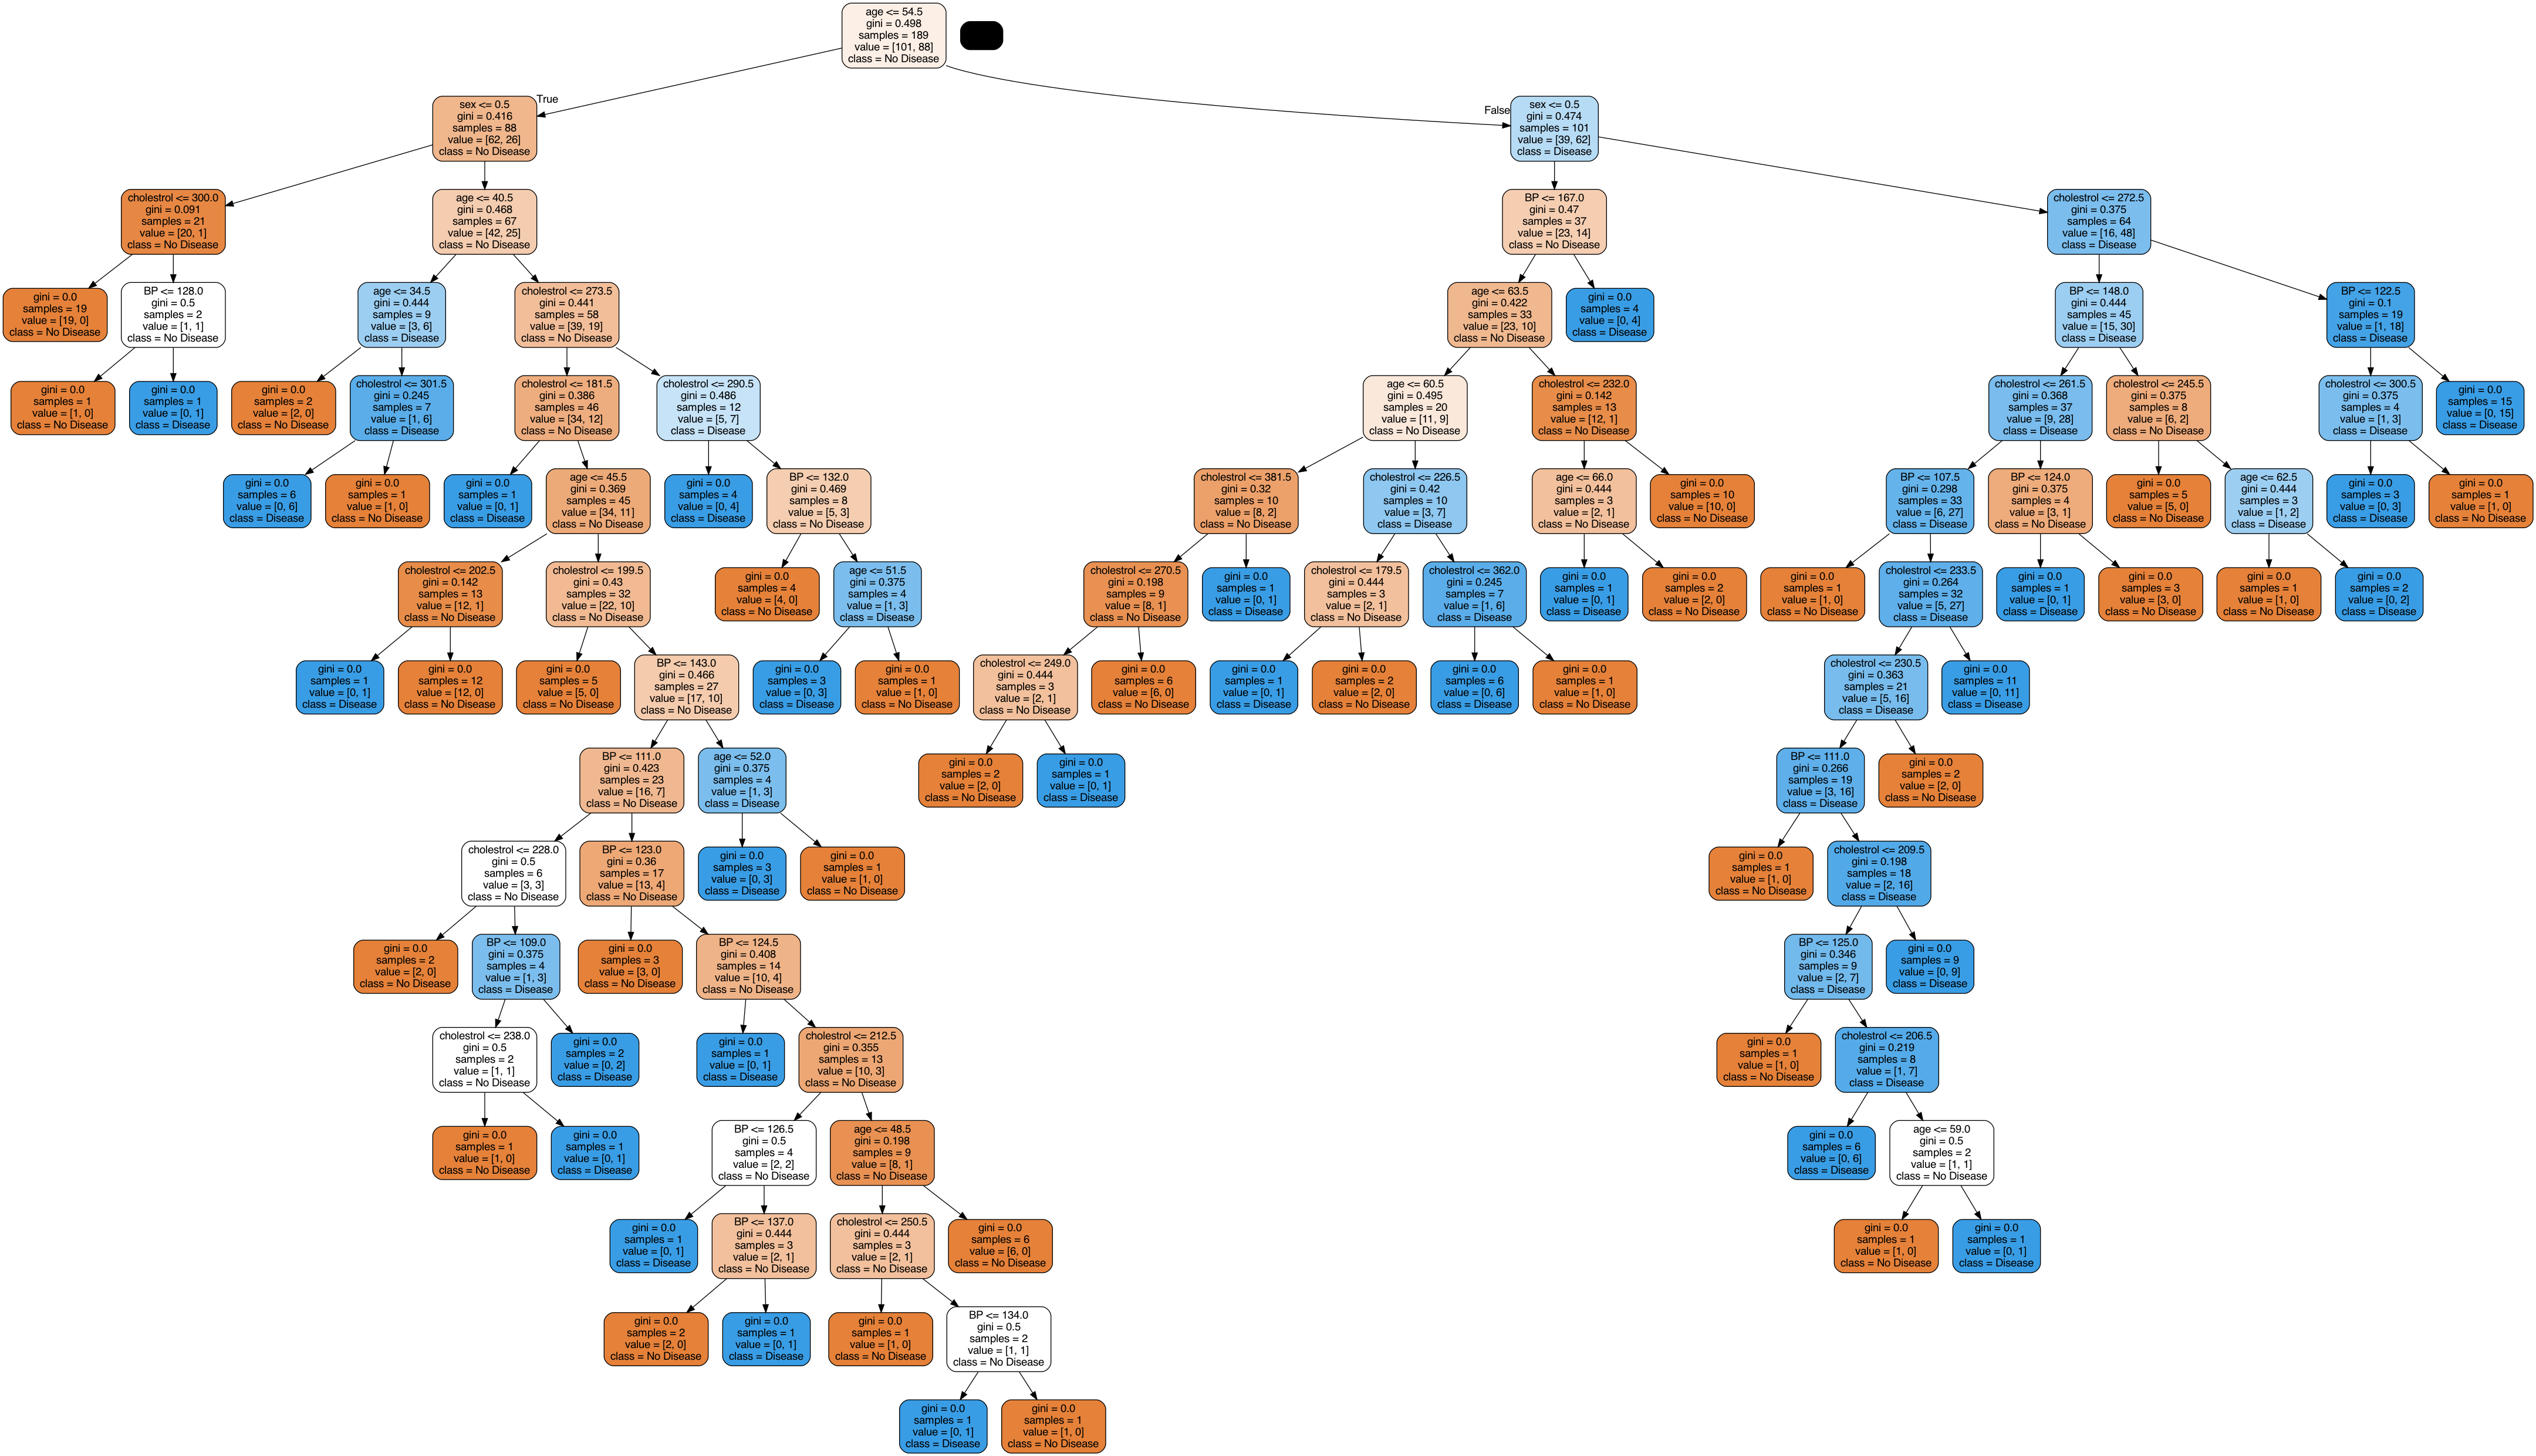

In [79]:
decision_tree_graph = get_dt_graph(dt_default)
Image(decision_tree_graph.create_png())

In [80]:
evaluate_model(dt_default)

#observation: If we compare Train and Test data we can see that model has mugged up the data due to which
# we got 100# accuracy while in the test dataset we got only 62.9% accuracy, so this explains the overfitting of the data

Train set performance
1.0
[[101   0]
 [  0  88]]
--------------------------------------------------
Test set performance
0.6296296296296297
[[31 18]
 [12 20]]


##### Decision Tree with max_depth parameter

In [81]:
dt_with_max_dept = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_with_max_dept.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

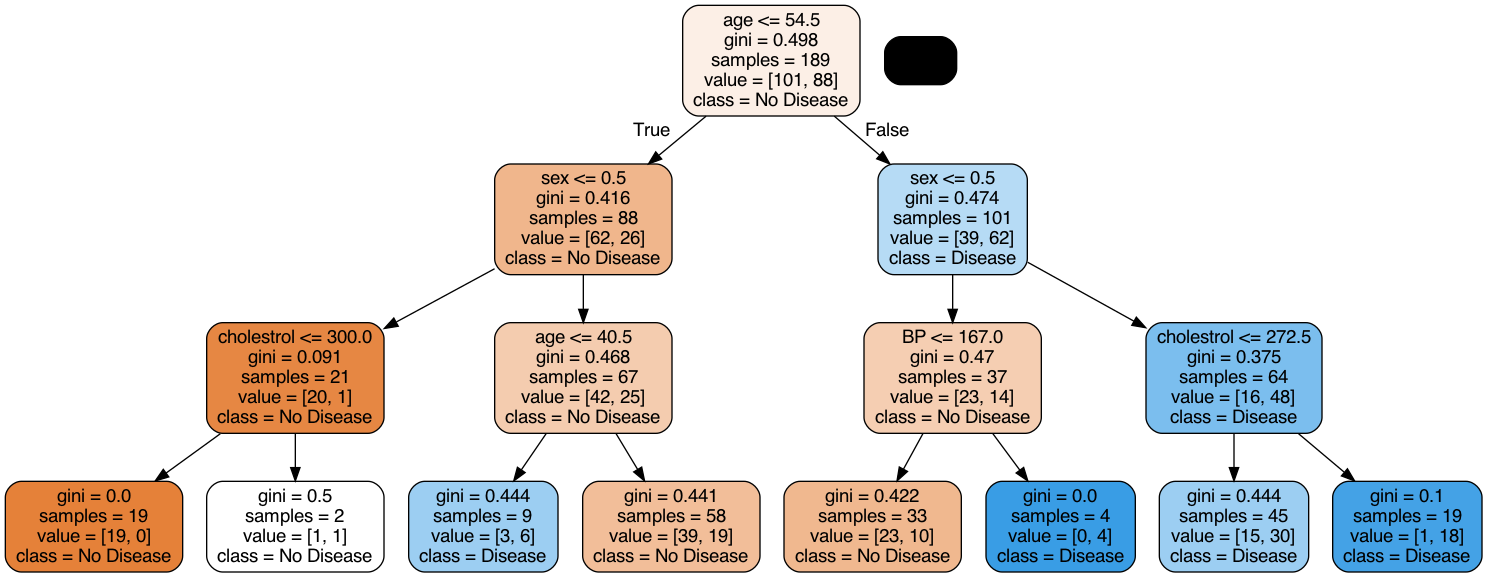

In [82]:
decision_tree_graph_with_max_depth = get_dt_graph(dt_with_max_dept)
Image(decision_tree_graph_with_max_depth.create_png())

In [83]:
evaluate_model(dt_with_max_dept)

Train set performance
0.7407407407407407
[[82 19]
 [30 58]]
--------------------------------------------------
Test set performance
0.6049382716049383
[[35 14]
 [18 14]]


##### Decision Tree with min_samples_split parameter

In [84]:
dt_with_min_samples_split = DecisionTreeClassifier(min_samples_split=20, random_state=42)
dt_with_min_samples_split.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_split=20, random_state=42)

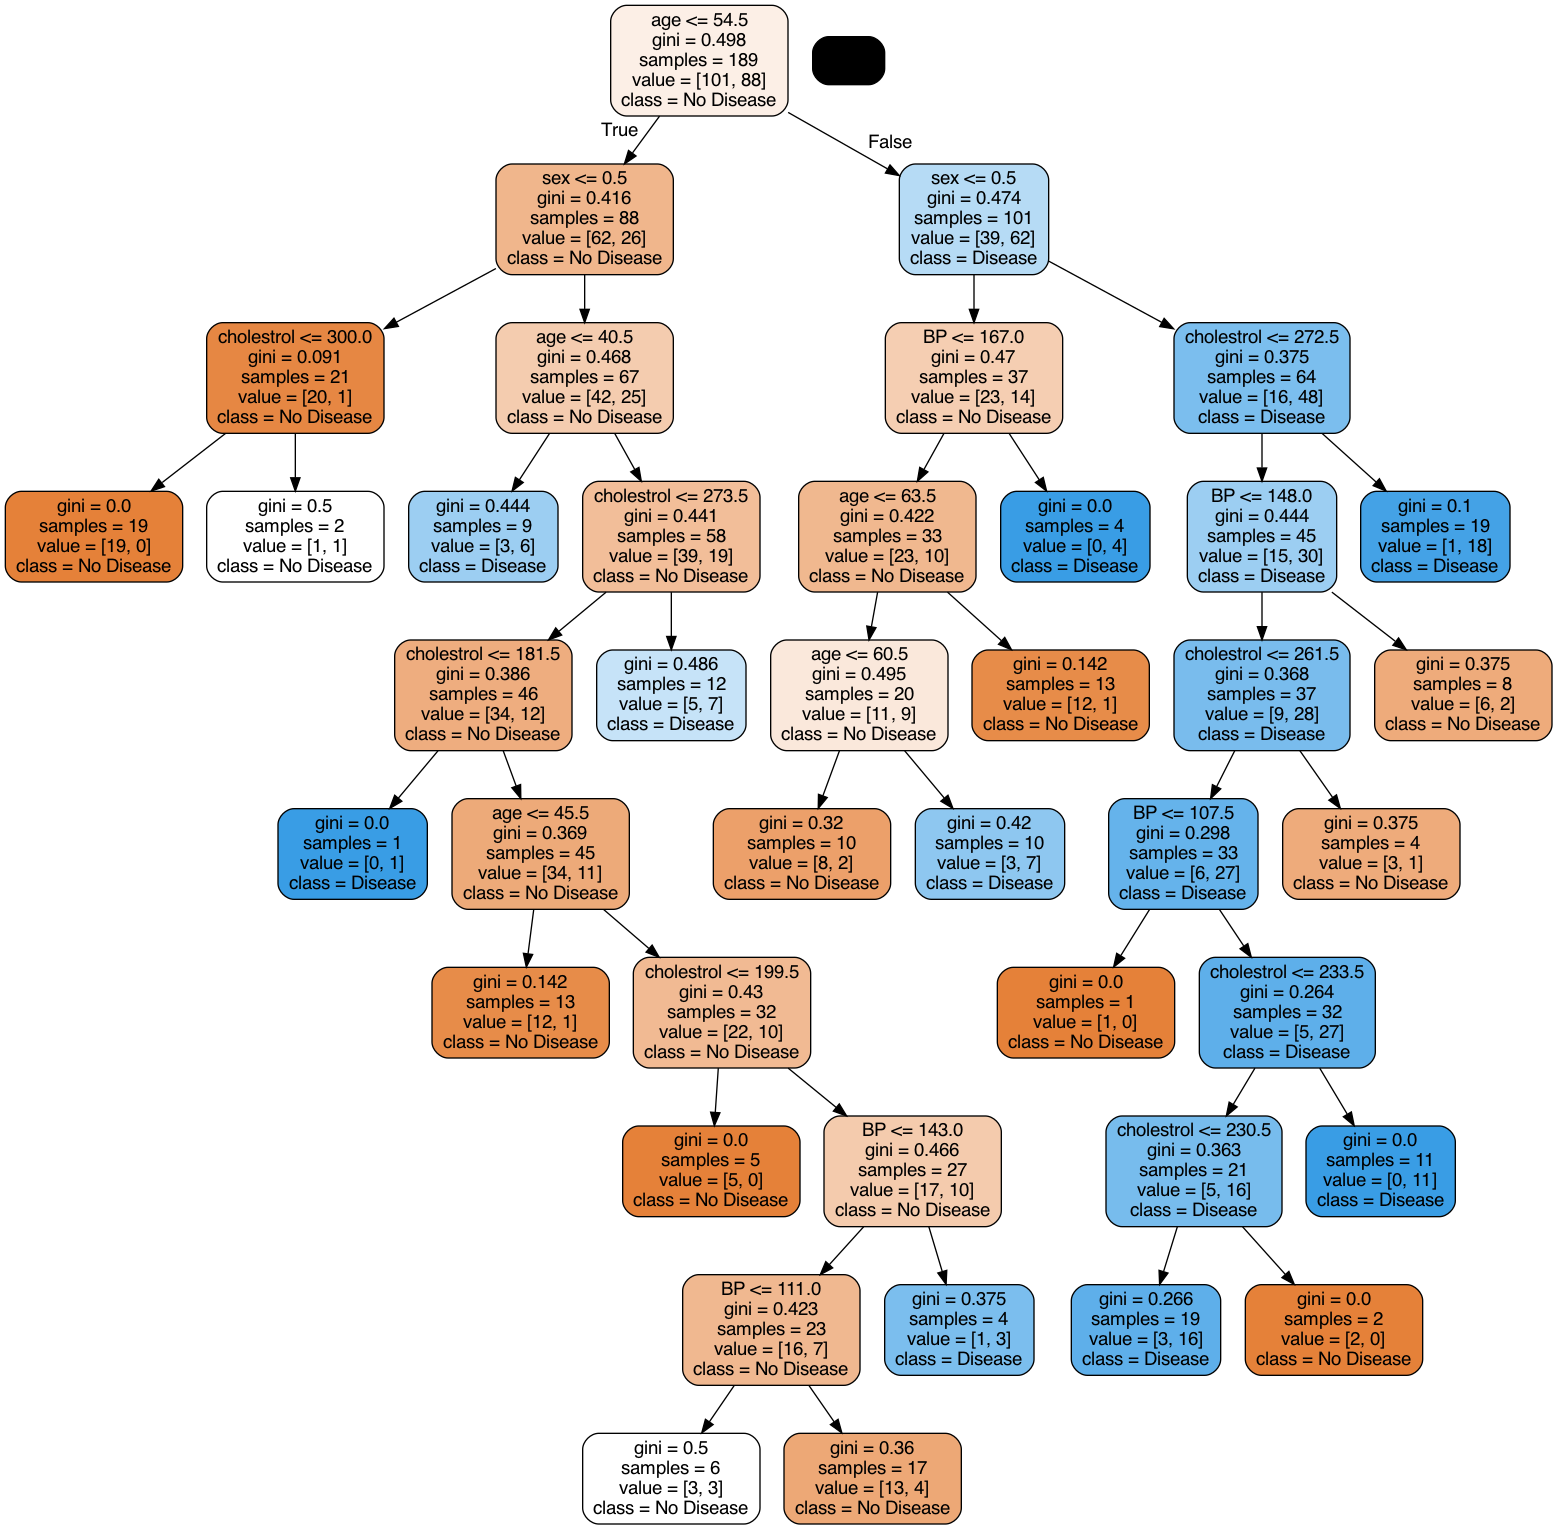

In [85]:
decision_tree_graph_with_min_samples_split = get_dt_graph(dt_with_min_samples_split)
Image(decision_tree_graph_with_min_samples_split.create_png())

In [86]:
evaluate_model(dt_with_min_samples_split)

Train set performance
0.8359788359788359
[[85 16]
 [15 73]]
--------------------------------------------------
Test set performance
0.6419753086419753
[[32 17]
 [12 20]]


##### Decision Tree with min_samples_leaf parameter

In [87]:
dt_with_min_samples_leaf = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
dt_with_min_samples_leaf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

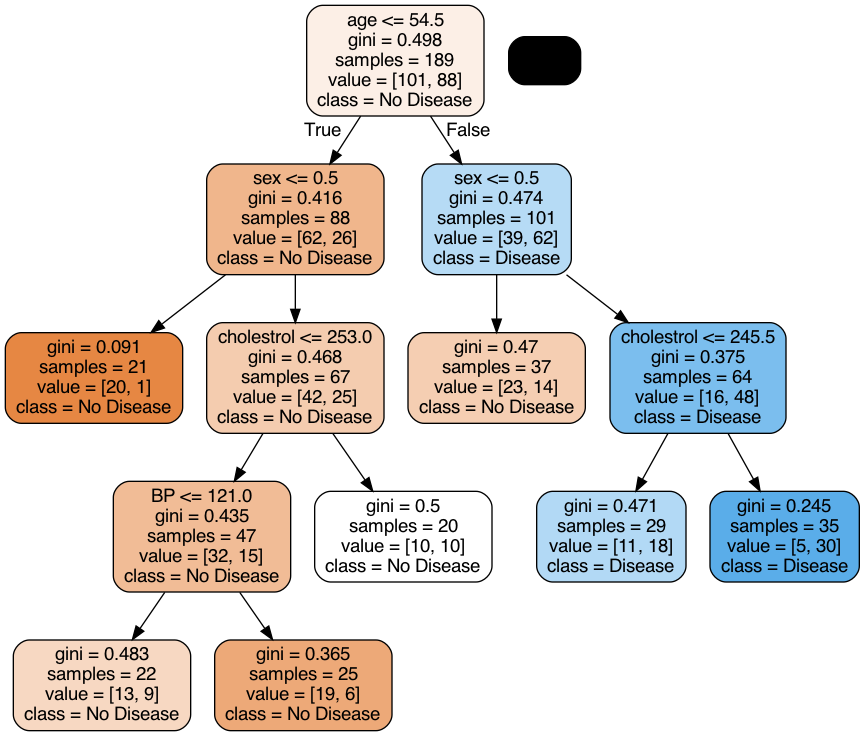

In [88]:
decision_tree_graph_with_min_samples_leaf = get_dt_graph(dt_with_min_samples_leaf)
Image(decision_tree_graph_with_min_samples_leaf.create_png())

In [89]:
evaluate_model(dt_with_min_samples_leaf)

Train set performance
0.7037037037037037
[[85 16]
 [40 48]]
--------------------------------------------------
Test set performance
0.6419753086419753
[[38 11]
 [18 14]]


##### Now let's try combining this parameter and check how much accuracy improvment we can get

In [90]:
dt_with_all_attributes = DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, random_state=42)
dt_with_all_attributes.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=20, random_state=42)

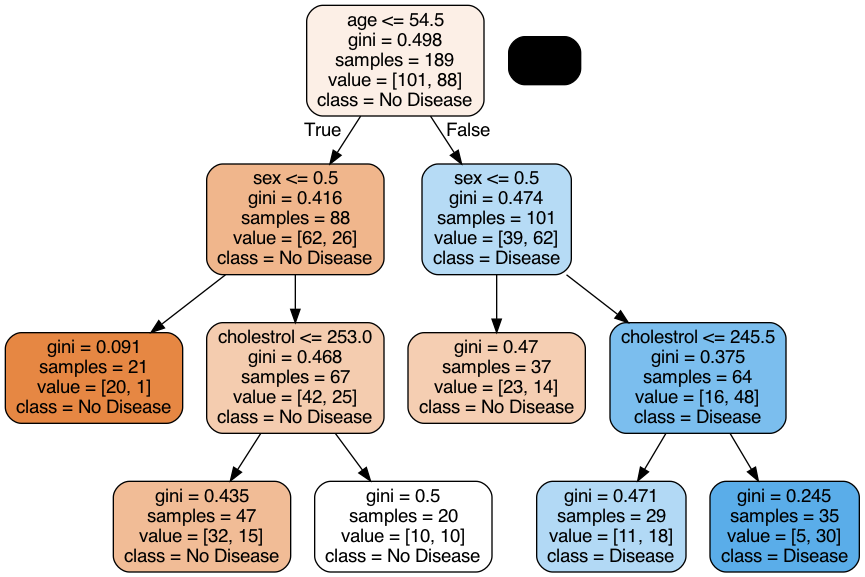

In [91]:
decision_tree_graph_with_all_attr = get_dt_graph(dt_with_all_attributes)
Image(decision_tree_graph_with_all_attr.create_png())

In [92]:
evaluate_model(dt_with_all_attributes)

# Observation: Though the depth of the model is changed and min_samples_leaf is same is before, there is no difference in the accuracy score.


Train set performance
0.7037037037037037
[[85 16]
 [40 48]]
--------------------------------------------------
Test set performance
0.6419753086419753
[[38 11]
 [18 14]]


##### Lets perform Hyperparameter tuning with Cross validation technique

In [93]:
newDecisionTree = DecisionTreeClassifier(random_state=42)

In [94]:
def perform_grid_cross_validation(split_count, estimator, hyper_params, scoring_scheme, random_state=100):
    # step-1: create a cross-validation scheme

    folds = KFold(n_splits = split_count, shuffle = True, random_state = random_state)    


    model_cv = GridSearchCV(estimator = estimator, 
                            param_grid = hyper_params, 
                            scoring= scoring_scheme, 
                            cv = folds, 
                            verbose = 1,
                            n_jobs=-1,
                            return_train_score=True)      

    # fit the model
    model_cv.fit(X_train, y_train)
    return model_cv

In [95]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100],
    'criterion': ["gini", "entropy"]
}
cross_validation_model = perform_grid_cross_validation(split_count=5,
                                                       estimator=newDecisionTree,
                                                       hyper_params=params,
                                                       scoring_scheme="accuracy")

Fitting 5 folds for each of 330 candidates, totalling 1650 fits


In [96]:
scoring_df = pd.DataFrame(cross_validation_model.cv_results_)
scoring_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.006601,0.004983,0.001418,0.001121,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.473684,0.763158,...,0.630156,0.112819,173,0.761589,0.715232,0.708609,0.715232,0.703947,0.720922,0.020777
1,0.005843,0.004676,0.001307,0.000790,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.473684,0.763158,...,0.630156,0.112819,173,0.761589,0.715232,0.708609,0.715232,0.703947,0.720922,0.020777
2,0.003288,0.002125,0.001340,0.000647,gini,2,15,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.473684,0.815789,...,0.640683,0.126377,166,0.761589,0.675497,0.701987,0.715232,0.703947,0.711650,0.028166
3,0.002168,0.001044,0.000919,0.000346,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.500000,0.815789,...,0.645946,0.119684,116,0.754967,0.675497,0.682119,0.715232,0.697368,0.705037,0.028473
4,0.001960,0.000860,0.000810,0.000427,gini,2,25,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.526316,0.815789,...,0.651209,0.113573,114,0.688742,0.675497,0.682119,0.715232,0.697368,0.691792,0.013776


In [97]:
cross_validation_model.best_estimator_

DecisionTreeClassifier(max_depth=3, min_samples_leaf=25, random_state=42)

In [98]:
scoring_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
19,0.002059,0.001271,0.000749,0.000576,gini,3,25,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.526316,0.815789,...,0.682788,0.094866,1,0.688742,0.675497,0.695364,0.715232,0.697368,0.694441,0.012908
34,0.000594,0.000011,0.000338,0.000005,gini,4,25,"{'criterion': 'gini', 'max_depth': 4, 'min_sam...",0.526316,0.815789,...,0.682788,0.094866,1,0.688742,0.675497,0.695364,0.715232,0.697368,0.694441,0.012908
49,0.000587,0.000006,0.000337,0.000004,gini,5,25,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.526316,0.815789,...,0.682788,0.094866,1,0.688742,0.675497,0.695364,0.715232,0.697368,0.694441,0.012908
64,0.001227,0.000687,0.000666,0.000383,gini,6,25,"{'criterion': 'gini', 'max_depth': 6, 'min_sam...",0.526316,0.815789,...,0.682788,0.094866,1,0.688742,0.675497,0.695364,0.715232,0.697368,0.694441,0.012908
79,0.001017,0.000868,0.000908,0.000784,gini,7,25,"{'criterion': 'gini', 'max_depth': 7, 'min_sam...",0.526316,0.815789,...,0.682788,0.094866,1,0.688742,0.675497,0.695364,0.715232,0.697368,0.694441,0.012908


In [99]:
# filtering best model from the cross validation
decision_tree_best_model = cross_validation_model.best_estimator_


In [100]:
evaluate_model(decision_tree_best_model)

Train set performance
0.7037037037037037
[[85 16]
 [40 48]]
--------------------------------------------------
Test set performance
0.6419753086419753
[[38 11]
 [18 14]]


In [101]:
print(classification_report(y_test, decision_tree_best_model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.68      0.78      0.72        49
           1       0.56      0.44      0.49        32

    accuracy                           0.64        81
   macro avg       0.62      0.61      0.61        81
weighted avg       0.63      0.64      0.63        81



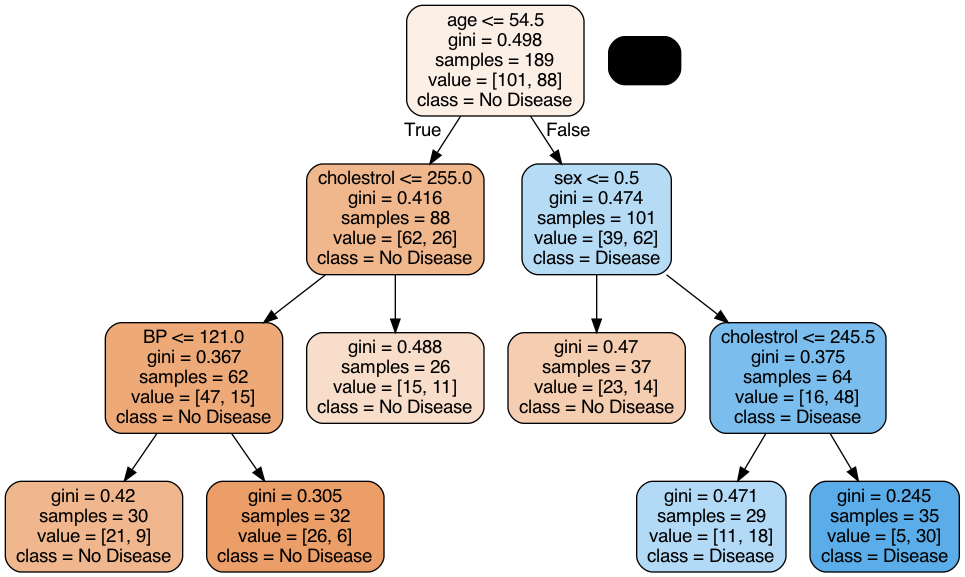

In [102]:
graph = get_dt_graph(decision_tree_best_model)
Image(graph.create_png())

##### Observation: The best model is have a depth of 3 and min samples leaf of 25

## Random Forest

In [103]:
randomForestClassifier = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3)

In [104]:
randomForestClassifier.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=42)

In [105]:
randomForestClassifier.estimators_[0]

DecisionTreeClassifier(max_depth=3, max_features='sqrt',
                       random_state=1608637542)

In [106]:
sample_tree = randomForestClassifier.estimators_[3]

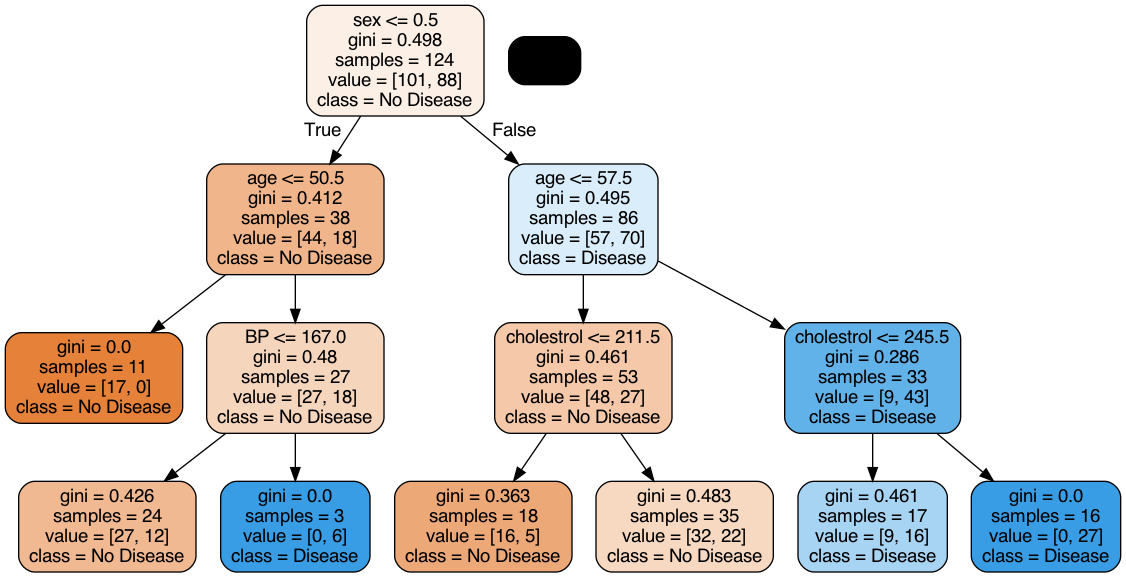

In [107]:
graph = get_dt_graph(sample_tree)
Image(graph.create_png(), width=700, height=700)

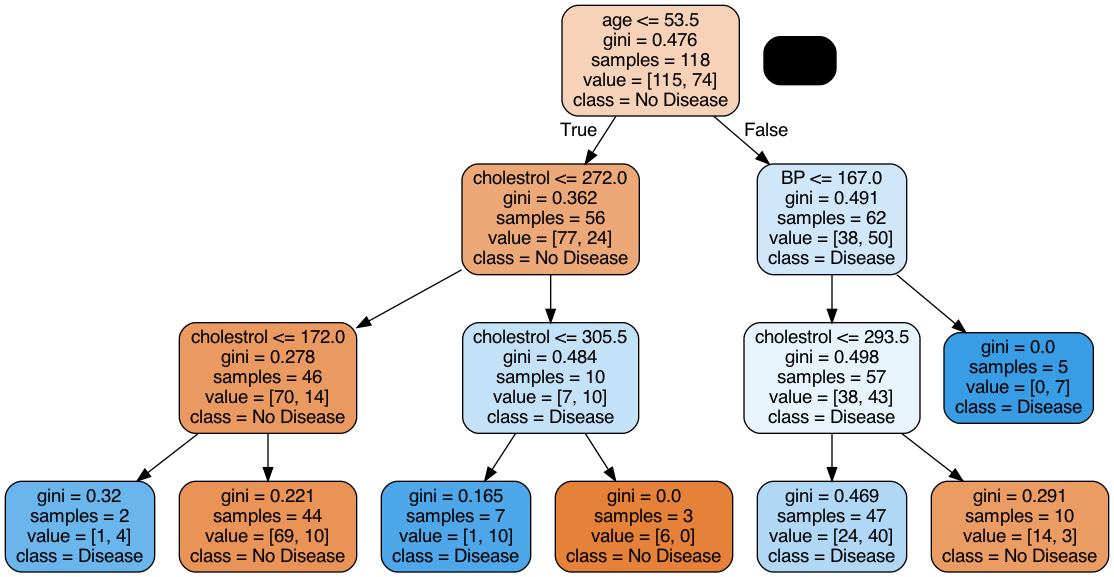

In [108]:
graph = get_dt_graph(randomForestClassifier.estimators_[2])
Image(graph.create_png(), width=700, height=700)

In [109]:
evaluate_model(randomForestClassifier)

Train set performance
0.7407407407407407
[[80 21]
 [28 60]]
--------------------------------------------------
Test set performance
0.6172839506172839
[[35 14]
 [17 15]]


### Hyperparameter Tuning for Random Forest

In [278]:
randomForestClassifier_tuned = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

In [279]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [1, 2, 3, 5, 10],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [2,3,4],
    'n_estimators': [10, 30, 40, 50, 100, 200]
}

In [280]:
random_forest_cv_model = GridSearchCV(estimator=randomForestClassifier_tuned, param_grid=params, 
                          cv=7, n_jobs=-1, verbose=1, scoring = "accuracy")

In [281]:
%%time
random_forest_cv_model.fit(X, y)

Fitting 7 folds for each of 450 candidates, totalling 3150 fits
CPU times: user 1.1 s, sys: 114 ms, total: 1.21 s
Wall time: 48.2 s


GridSearchCV(cv=7,
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 40, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [282]:
random_forest_scoring_df = pd.DataFrame(random_forest_cv_model.cv_results_)
random_forest_scoring_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
0,0.029208,0.005069,0.007300,0.001552,1,2,5,10,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.769231,0.641026,0.615385,0.538462,0.605263,0.736842,0.631579,0.648255,0.073481,240
1,0.036124,0.005521,0.009552,0.000984,1,2,5,30,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.717949,0.641026,0.589744,0.615385,0.657895,0.736842,0.710526,0.667052,0.051767,107
2,0.043838,0.004536,0.016998,0.013690,1,2,5,40,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.717949,0.641026,0.564103,0.641026,0.684211,0.736842,0.710526,0.670812,0.055420,76
3,0.062255,0.007639,0.008286,0.002011,1,2,5,50,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.717949,0.641026,0.564103,0.641026,0.684211,0.736842,0.684211,0.667052,0.053457,107
4,0.166251,0.036517,0.013828,0.005780,1,2,5,100,"{'max_depth': 1, 'max_features': 2, 'min_sampl...",0.717949,0.641026,0.564103,0.692308,0.684211,0.736842,0.710526,0.678138,0.054378,19


In [283]:
random_forest_scoring_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,mean_test_score,std_test_score,rank_test_score
421,0.061639,0.010754,0.011100,0.006775,10,4,5,30,"{'max_depth': 10, 'max_features': 4, 'min_samp...",0.743590,0.641026,0.641026,0.743590,0.710526,0.736842,0.736842,0.707634,0.043381,1
302,0.070579,0.006839,0.008042,0.001449,5,3,5,40,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.769231,0.666667,0.641026,0.692308,0.684211,0.710526,0.710526,0.696356,0.037453,2
271,0.048442,0.007000,0.011686,0.006502,5,2,5,30,"{'max_depth': 5, 'max_features': 2, 'min_sampl...",0.743590,0.666667,0.666667,0.717949,0.631579,0.763158,0.684211,0.696260,0.043534,3
278,0.060483,0.013661,0.007371,0.002075,5,2,10,40,"{'max_depth': 5, 'max_features': 2, 'min_sampl...",0.743590,0.717949,0.564103,0.717949,0.657895,0.736842,0.684211,0.688934,0.057984,4
331,0.048595,0.010031,0.008660,0.004777,5,4,5,30,"{'max_depth': 5, 'max_features': 4, 'min_sampl...",0.717949,0.615385,0.666667,0.743590,0.631579,0.710526,0.736842,0.688934,0.047488,4


In [284]:
random_forest_cv_best = random_forest_cv_model.best_estimator_

In [285]:
random_forest_cv_oob_score = random_forest_cv_model.best_estimator_.oob_score_
print(random_forest_cv_oob_score)

0.6296296296296297


In [286]:
random_forest_cv_best


RandomForestClassifier(max_depth=10, max_features=4, min_samples_leaf=5,
                       n_estimators=30, n_jobs=-1, oob_score=True,
                       random_state=42)

In [287]:
evaluate_model(random_forest_cv_best)

Train set performance
0.8412698412698413
[[88 13]
 [17 71]]
--------------------------------------------------
Test set performance
0.8518518518518519
[[46  3]
 [ 9 23]]


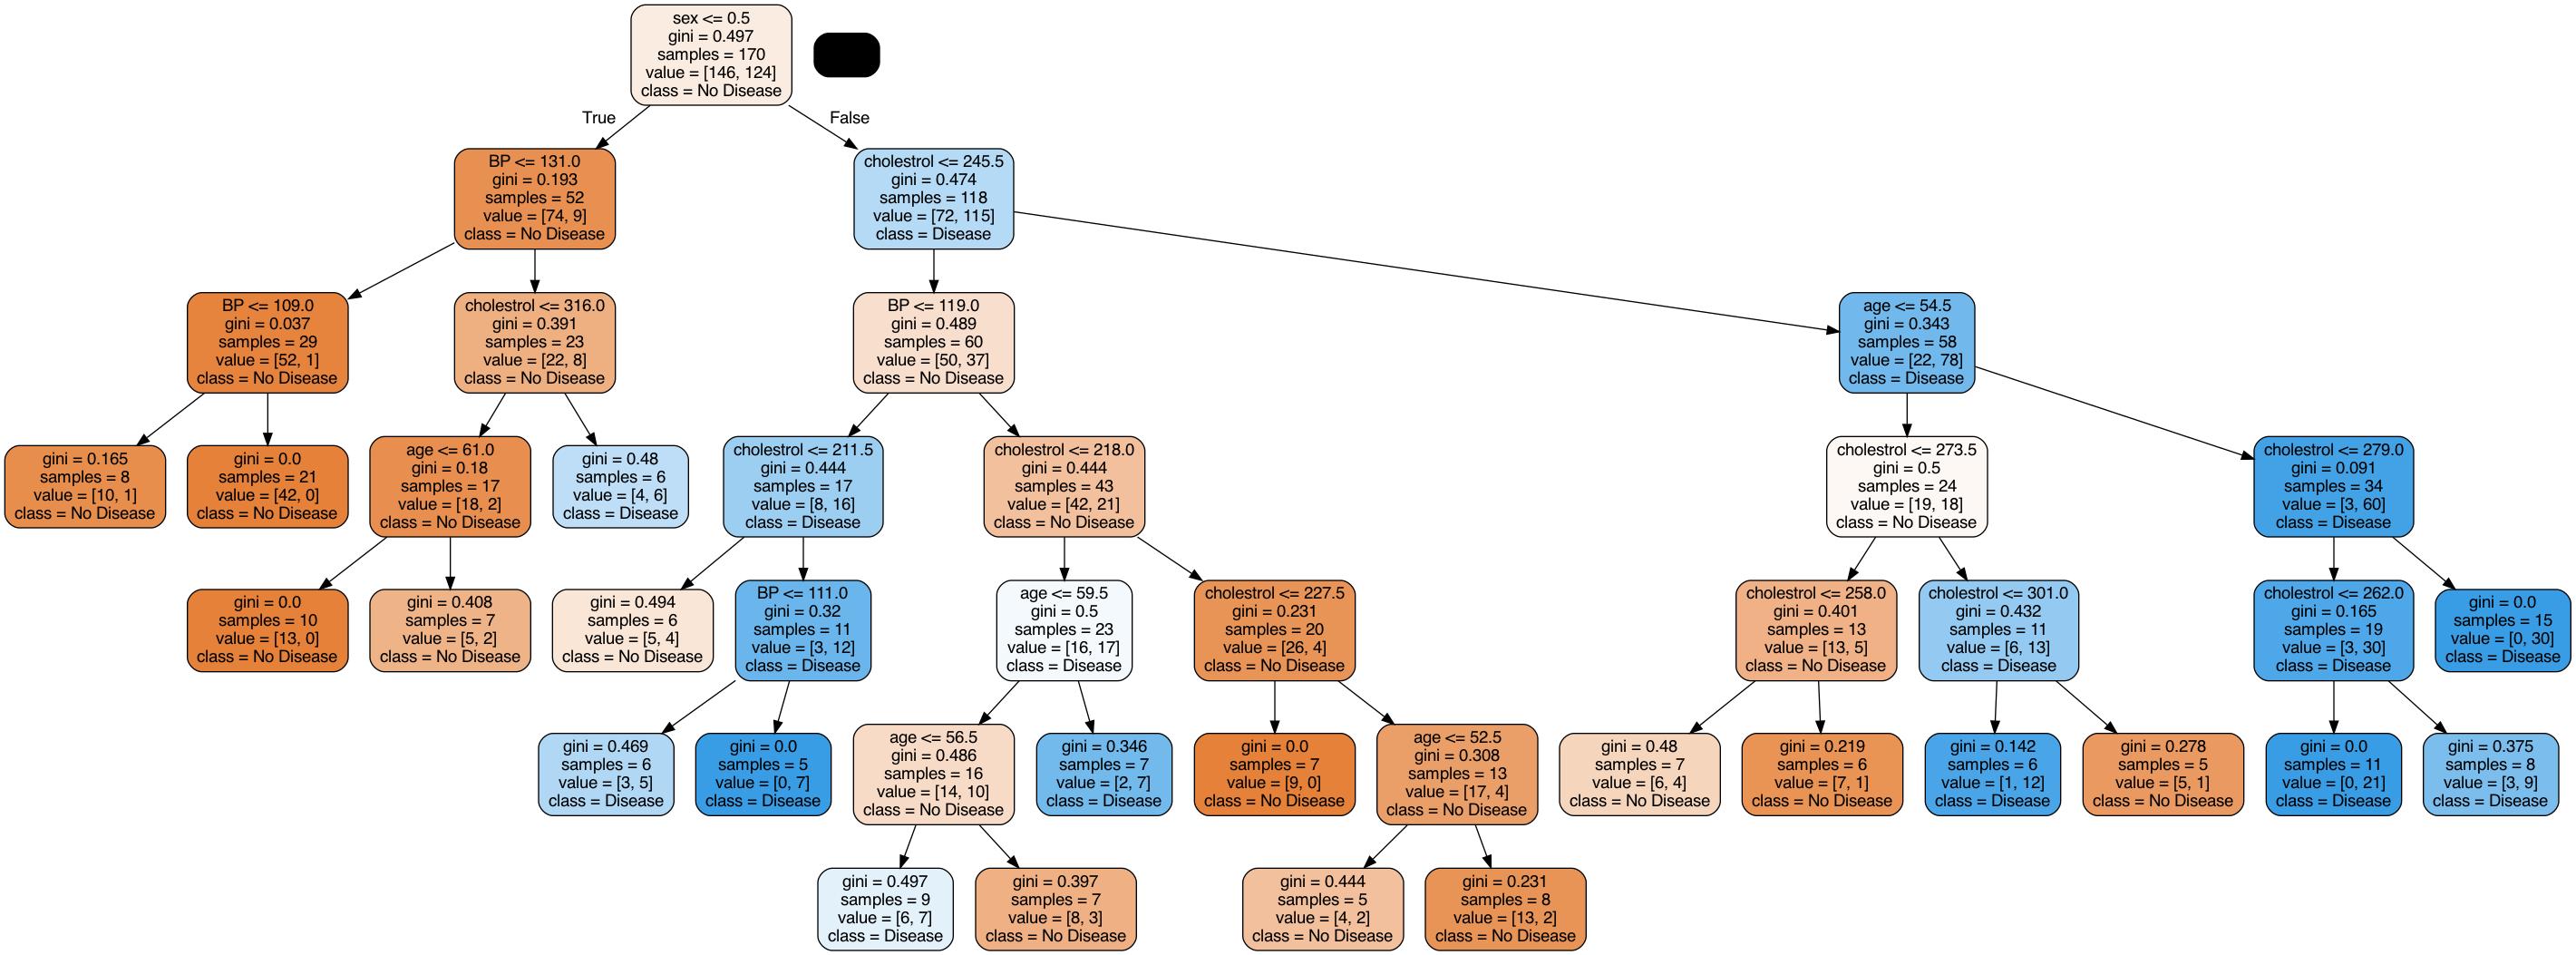

In [288]:
graph = get_dt_graph(random_forest_cv_best.estimators_[0])
Image(graph.create_png(), width=900, height=900)

### Variable importance in Random Forest and Decision trees

In [289]:
random_forest_cv_best.feature_importances_

array([0.33141168, 0.1735033 , 0.18483385, 0.31025118])

In [290]:
imp_df = pd.DataFrame({
    "Varname": X_train.columns,
    "Imp": random_forest_cv_best.feature_importances_
})

In [291]:
imp_df.sort_values(by="Imp", ascending=False)

,Varname,Imp
0,age,0.331412
3,cholestrol,0.310251
2,BP,0.184834
1,sex,0.173503


In [292]:
print(classification_report(y_test, random_forest_cv_best.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.94      0.88        49
           1       0.88      0.72      0.79        32

    accuracy                           0.85        81
   macro avg       0.86      0.83      0.84        81
weighted avg       0.86      0.85      0.85        81



## Observations:
1. Age, Cholestrol, BP, Sex in descending order shows the importance of predicting if the patient have Heart disease or not
2. After tuning the model with 7 folds we got Out of Bag error score of 62.96% which was better when I used other kfolds values
3. We can see Test accuracy is 1% more than the train accuracy this is interesting as it tells that our model is generalized well and there is no overfitting happened and with the less data size it is performing well.